In [1]:
#Import necessary libraries.
import numpy as np
from numpy import loadtxt
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import matplotlib.animation as animation

In [2]:
#Finds the z coordinate of the centre of mass
#We assume we have circular cross sections, due to axisymmetry, and constant density. This gives the r coordinate as 0 for free.
def com(r,z):
    return np.sum(z*r**2)/np.sum(r**2)

In [3]:
#Define the nondimensional ODE system.
def zrODE(y,t, Bod,Ohd,Wed,Ca,Nw):
    #Split into the different components
    z, v, r, u = y
    
    #Define the contact force, which is 0 when the expression is negative
    f = (1/2)*(1 + (1/Bod)*(Ca*v - 3.8*Ohd*v - Nw*(z-1)))
    
    #Define the ODEs. At this point, the mathematical reasoning is somewhat out of the window, and I am just doing what works.
    zdot = v.copy()
    if z-r>0 or f<=0:        
        rdot = u.copy()
        vdot = -Ca*v - Bod
        udot = -3.8*Ohd*u - Nw*(r-1)
    else:
        rdot = zdot
        vdot = -Ca*v + Bod*(f-1)
        udot = -3.8*Ohd*u - Nw*(r-1) - Bod*f
    
    return zdot, vdot, rdot, udot

In [4]:
#Define the dimensional parameters.
#Drop parameters.
R   = 0.0005
pd  = 917.2     #density
mud = 0.084     #dynamic viscosity
vd  = mud/pd    #kinematic viscosity
U   = 0.25

#Air parameters.
pa  = 1.20
mua = 1.813*10**(-5)
va  = mua/pa

#Others.
st  = 0.0320    #surface tension
g   = 9.81

#Time scale.
T   = np.sqrt((pd*(R**3))/st)

#Nondimensional parameters.
Rea = U*R/va
Bod = pd*g*R*R/st
Ohd = vd*np.sqrt(pd/(st*R))
Wed = pd*U*U*R/st
Nw  = 5.84
Ca  = ((9*pa*va*T)/(2*R*R*pd))*(1+(Rea/6))
V   = -np.sqrt(Wed)

In [5]:
#Define the initial condition.
y0 = np.array([2,V,1,0])

#Set up the time array.
tf = 10
t =  np.linspace(0,tf,10000*tf+1)

#Compute the solution, and split it into the different parts.
y_sol = odeint(zrODE, y0, t, args=(Bod,Ohd,Wed,Ca,Nw))

z_sol = y_sol[:,0]
v_sol = y_sol[:,1]
r_sol = y_sol[:,2]
u_sol = y_sol[:,3]

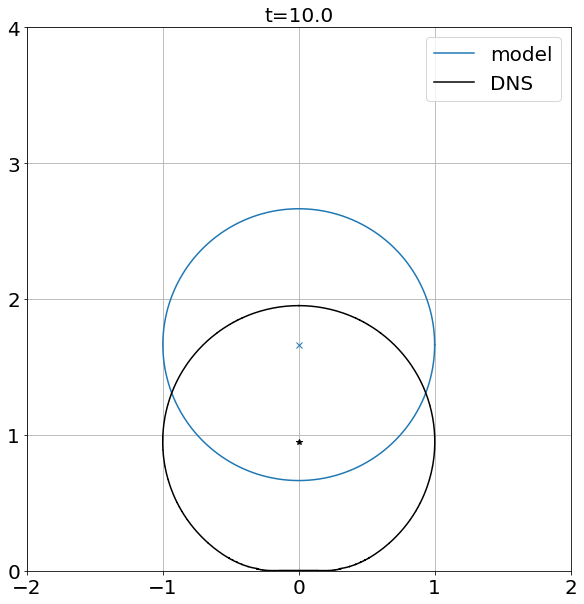

In [11]:
#Initialise the plot.
fig, ax = plt.subplots()

#Set up a parameterisation variable for the interface shape.
theta = np.linspace(0,2*np.pi,1001)

b = r_sol[0]
a = np.sqrt(1/b)

#Set up the frame by extracting the data from the .dat file and splitting it up.
#We require all the .dat files to be in the same folder as this code file for it to run.
data = loadtxt('interfaceDrop-0.0.dat')

#Sort the array so it is in ascending z.
data = data[data[:,0].argsort()]

data1 = 4*np.ones(len(data[:,0])) + data[:,0]
data2 = data[:,1]

#Find the centre of mass for the frame.
zcom = com(data2,data1)

line1, = ax.plot(a*np.cos(theta),z_sol[0]+b*np.sin(theta), '-', color='#1f77b4', label='model')
line2, = ax.plot( 0, z_sol[0], marker="x", color='#1f77b4')
line3, = ax.plot( data2, data1, color='black', label='DNS')
line4, = ax.plot(-data2, data1, color='black')
line5, = ax.plot( 0, zcom, marker="*", color='black')

#Set up each frame to be plotted.
def animate(i):
    j = 1000*i
    
    #Find the axes lengths at the given time.
    b = r_sol[j]
    a = np.sqrt(1/b)
    
    #Update the interface position.
    line1.set_xdata(a*np.cos(theta)),
    line1.set_ydata(z_sol[j]+b*np.sin(theta))
    
    #Update the com position.
    line2.set_ydata(z_sol[j])
    
    #Extract the data from the .dat file and split into two arrays.
    newdata = loadtxt('interfaceDrop-'+str(np.round(i*0.1,2))+'.dat')
    
    #Sort the array so it is in ascending z.
    newdata = newdata[newdata[:,0].argsort()]
    
    newdata1 = 4*np.ones(len(newdata[:,0])) + newdata[:,0]
    newdata2 = newdata[:,1]
    
    #Find the centre of mass in this frame.
    newzcom = com(newdata2,newdata1)
    
    #Update the right half of the drop.
    line3.set_xdata( newdata2)
    line3.set_ydata( newdata1)  
    
    #Update the left half of the drop.
    line4.set_xdata(-newdata2)
    line4.set_ydata( newdata1)
    
    #Update the centre of mass z position.
    line5.set_ydata( newzcom)
    
    #Title giving the frame the time
    ax.set_title("t="+str(np.round(i/10,2)), fontsize=20)
    return line1, line2,

#Add details and set the figure shape/size.
fig.set_size_inches(10,10)
ax.axis('equal')
ax.set_aspect('equal', adjustable='box')
ax.tick_params(axis='both', which='major', labelsize=20)

ax.set_xlim(-2,2)
ax.set_xticks(np.arange(-2,3,1))

ax.set_ylim(-0,4)
ax.set_yticks(np.arange(-0,5,1))

ax.legend(fontsize=20)

ax.grid()

#Make the animation.
ani = animation.FuncAnimation(fig, animate, interval=2, frames=101, blit=True, save_count=101)

#Save the figure as a gif. Low fps is used to slow it down.
writergif = animation.PillowWriter(fps=10)
ani.save('oil_droplet_interface_shape_comparison.gif',writer=writergif)

plt.show()